## Now with SORT tracking

Using a sort implementation originally by Alex Bewley, but adapted by [Chris Fotache](https://github.com/cfotache/pytorch_objectdetecttrack/blob/master/README.md). For an example implementation, see [his notebook](https://github.com/cfotache/pytorch_objectdetecttrack/blob/master/PyTorch_Object_Tracking.ipynb).



In [1]:
import cv2
from pathlib import Path
import numpy as np
from PIL import Image
import torch
from torchvision.io.video import read_video
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
        

In [2]:
source = Path('../DATASETS/VIRAT_subset_0102x')
videos = source.glob('*.mp4')

In [4]:
video_path = list(videos)[0]
video_path = Path("../DATASETS/VIRAT_subset_0102x/VIRAT_S_010200_00_000060_000218.mp4")
video_path

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Based on code from: https://stackabuse.com/retinanet-object-detection-with-pytorch-and-torchvision/

In [7]:
weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
model = retinanet_resnet50_fpn_v2(weights=weights, score_thresh=0.35)
model.to(device)
# Put the model in inference mode
model.eval()
# Get the transforms for the model's weights
preprocess = weights.transforms().to(device)

In [8]:
# hub.set_dir()

In [9]:
video = cv2.VideoCapture(str(video_path))

> The score_thresh argument defines the threshold at which an object is detected as an object of a class. Intuitively, it's the confidence threshold, and we won't classify an object to belong to a class if the model is less than 35% confident that it belongs to a class.

The result from a single prediction coming from `model(batch)` looks like:

```python
{'boxes': tensor([[5.7001e+02, 2.5786e+02, 6.3138e+02, 3.6970e+02],
         [5.0109e+02, 2.4508e+02, 5.5308e+02, 3.4852e+02],
         [3.4096e+02, 2.7015e+02, 3.6156e+02, 3.1857e+02],
         [5.0219e-01, 3.7588e+02, 9.7911e+01, 7.2000e+02],
         [3.4096e+02, 2.7015e+02, 3.6156e+02, 3.1857e+02],
         [8.3241e+01, 5.8410e+02, 1.7502e+02, 7.1743e+02]]),
 'scores': tensor([0.8525, 0.6491, 0.5985, 0.4999, 0.3753, 0.3746]),
 'labels': tensor([64, 64,  1, 64, 18, 86])}
```

In [10]:
from sort_cfotache import Sort

mot_tracker = Sort()

display_image = False

/home/ruben/suspicion/trajpred/sort_cfotache.py:36: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iou(bb_test,bb_gt):


In [11]:
tracked_instances = {}

In [12]:
# TODO make into loop
%matplotlib inline


import pylab as pl
from IPython import display
from utils.timer import Timer

i=0
timer = Timer()
while True:
    timer.tic()
    ret, frame = video.read()
    i+=1
    
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    t = torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    t.shape
    # change axes of image loaded image to be compatilbe with torch.io.read_image (which has C,W,H format instead of W,H,C)
    t = t.permute(2, 0, 1)
    t.shape

    batch = preprocess(t)[None, :].to(device)
    # no_grad can be used on inference, should be slightly faster
    with torch.no_grad():
        predictions = model(batch)
    prediction = predictions[0] # we feed only one frame at the once

    mask = prediction['labels'] == 1 # if we want more than one: np.isin(prediction['labels'], [1,86])

    scores = prediction['scores'][mask]
    labels = prediction['labels'][mask]
    boxes = prediction['boxes'][mask]
    
    # TODO: introduce confidence and NMS supression: https://github.com/cfotache/pytorch_objectdetecttrack/blob/master/PyTorch_Object_Tracking.ipynb
    # (which I _think_ we better do after filtering)
    # alternatively look at Soft-NMS https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c

    
    #  dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
    detections = np.array([np.append(bbox, [score, label]) for bbox, score, label in zip(boxes.cpu(), scores.cpu(), labels.cpu())])
    # print(detections)
    tracks = mot_tracker.update(detections)

    # now convert back to boxes and labels
    # print(tracks)
    boxes = np.array([t[:4] for t in tracks])
    # initialize empty with the necesserary dimensions for drawing_bounding_boxes glitch
    t_boxes = torch.from_numpy(boxes) if len(boxes) else torch.Tensor().new_empty([0, 6])
    labels = [str(int(t[4])) for t in tracks]
    # print(t_boxes, boxes, labels)


    for track in tracks:
        # TODO add to tracked_instances
        track_id = str(int(track[4]))
        if track_id not in tracked_instances:
            tracked_instances[track_id] = []
        tracked_instances[track_id].append(track)

    
    # labels = [weights.meta["categories"][i] for i in labels]

    if display_image:
        box = draw_bounding_boxes(t, boxes=t_boxes,
                                labels=labels,
                                colors="cyan",
                                width=2, 
                                font_size=30,
                                # font='Arial'
                                )

        im = to_pil_image(box.detach())

        display.display(im, f"frame {i}")
    # print(prediction)
    print("time for frame: ", timer.toc(), ", avg:", 1/timer.average_time, "fps")

    display.clear_output(wait=True)

    # break # for now
    # pl.clf()
    # # pl.plot(pl.randn(100))
    # pl.figure(figsize=(24,50))
    # # fig.axes[0].imshow(img)
    # pl.imshow(im)
    # display.display(pl.gcf(), f"frame {i}")
    # display.clear_output(wait=True)
    # time.sleep(1.0)

    # fig, ax = plt.subplots(figsize=(16, 12))
    # ax.imshow(im)
    # plt.show()



Can't receive frame (stream end?). Exiting ...


## Project / Homography

Now that all trajectories are captured (for a single video), these can then be projected onto a flat surface by [homography](https://en.wikipedia.org/wiki/Homography_(computer_vision)). The necessary $H$ matrix is already provided by VIRAT in the [homographies folder](https://data.kitware.com/#folder/56f581c88d777f753209c9d2) of their online data repository.

In [ ]:

homography = list(source.glob('*img2world.txt'))[0]
H = np.loadtxt(homography, delimiter=',')



The homography matrix helps to transform points from image space to a flat world plane. The `README_homography.txt` from VIRAT describes:

> Roughly estimated 3-by-3 homographies are included for convenience. 
> Each homography H provides a mapping from image coordinate to scene-dependent world coordinate.
>   
> [xw,yw,zw]' = H*[xi,yi,1]'
> 
> xi: horizontal axis on image with left top corner as origin, increases right.
> yi: vertical axis on image with left top corner as origin, increases downward.
> 
> xw/zw: world x coordinate
> yw/zw: world y coordiante

(1200, 900)


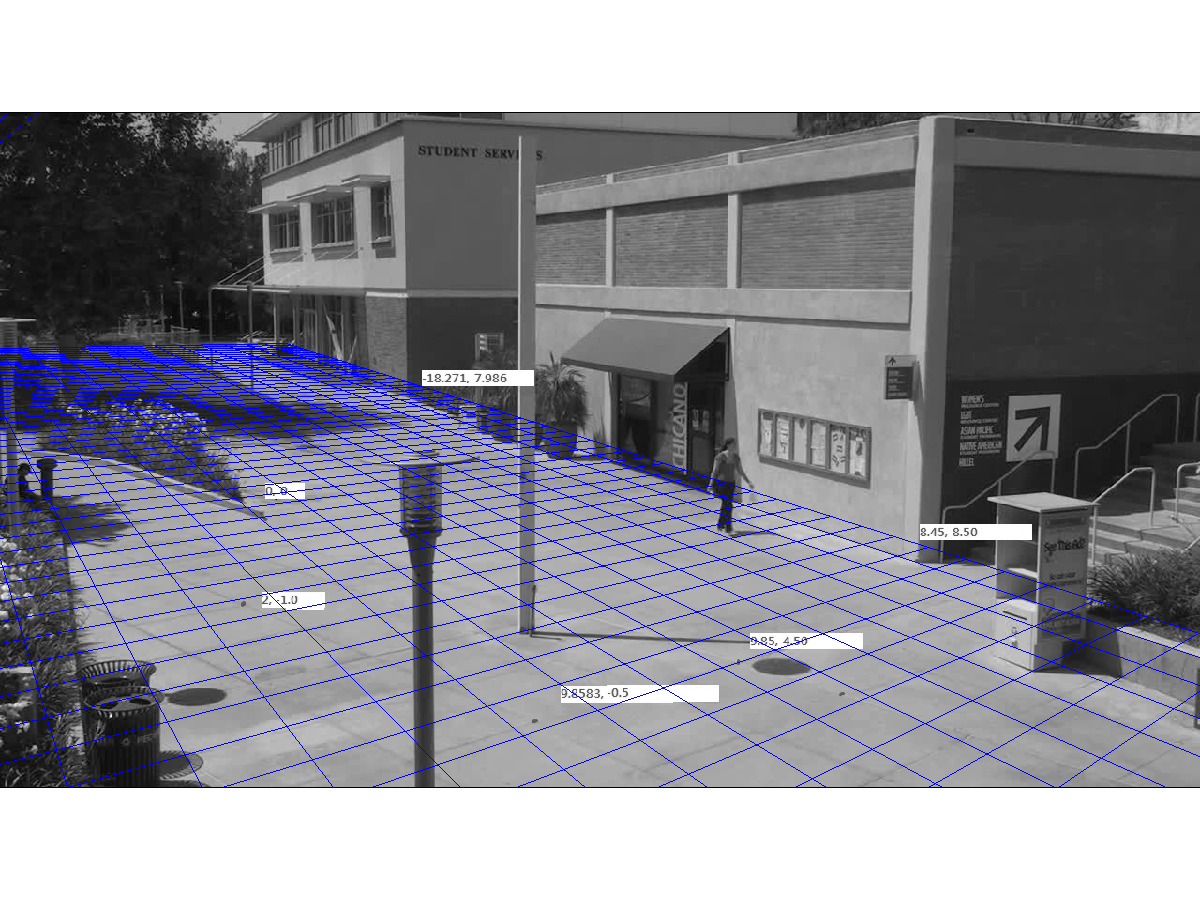

In [13]:
print(Image.open("../DATASETS/VIRAT_subset_0102x/VIRAT_0102_homography_img2world.png").size)
Image.open("../DATASETS/VIRAT_subset_0102x/VIRAT_0102_homography_img2world.png")


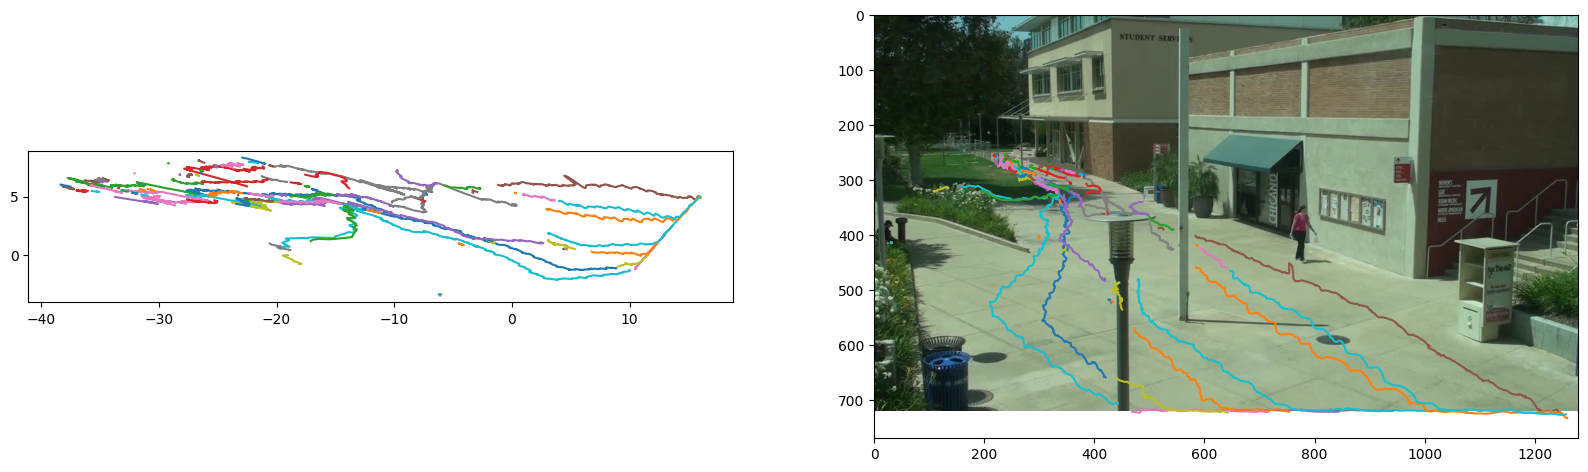

: 

In [17]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20,8))
ax1, ax2 = fig.subplots(1,2)

ax1.set_aspect(1)
ax2.imshow(Image.open("../DATASETS/VIRAT_subset_0102x/VIRAT_S_0102.jpg"))

for track_id in tracked_instances:
    # print(track_id)
    bboxes = tracked_instances[track_id]
    traj = np.array([[[0.5 * (det[0]+det[2]), det[3]]] for det in bboxes])
    projected_traj = cv2.perspectiveTransform(traj,H)
    # plt.plot(projected_traj[:,0])
    ax1.plot(projected_traj[:,:,0].reshape(-1), projected_traj[:,:,1].reshape(-1))
    ax2.plot(traj[:,:,0].reshape(-1), traj[:,:,1].reshape(-1))
    
plt.show()        